## Question 2: Bias by Label - Lindsey

Are the albums from one label rated differently than the wider population? In other words, does Pitchfork rate a certain record label more highly (or more harshly)
than others?

- *Alternative Hypothesis:* Average Pitchfork reviews are significantly higher for one record label compared to the others.
- *Null Hypothesis:* Average Pitchfork reviews are not significantly different for different record labels.

In [1]:
# Imports

import sqlite3
import pandas as pd
import numpy as np
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

In [2]:
# Creating connection to SQL database

conn = sqlite3.Connection("database.sqlite")
c = conn.cursor()

In [3]:
# Querying for our reviews, scores and record labels

c.execute("""SELECT score, 
                    label
             FROM labels
             JOIN reviews
             USING(reviewid);""")

# Creating a pandas dataframe from our SQLite query
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,score,label
0,9.3,virgin
1,7.9,hathenter
2,7.3,static shock
3,7.3,fashionable idiots
4,9.0,kill rock stars


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20200 entries, 0 to 20199
Data columns (total 2 columns):
score    20200 non-null float64
label    20162 non-null object
dtypes: float64(1), object(1)
memory usage: 315.7+ KB


In [5]:
# Since we are looking specifically at average scores as they relate to record 
# labels, we need to drop the rows where there is no label data

# Dropping rows where label is null
df.dropna(inplace=True)

# There are also rows where label is blank, not null, so dropping those too
list_empty_labels = list(df.loc[df["label"] == ""].index)
df = df.drop(list_empty_labels)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20153 entries, 0 to 20199
Data columns (total 2 columns):
score    20153 non-null float64
label    20153 non-null object
dtypes: float64(1), object(1)
memory usage: 472.3+ KB


In [7]:
# Creating a new dataframe specifically looking at instances of our labels

# Creating a column for average scores
label_df = df.groupby("label").mean()[["score"]]
label_df.rename(columns={"score": "avg_score"}, inplace=True)

# Adding a column with the count of each label to our new label dataframe

label_df["count"] = df.groupby("label").count()[["score"]]
label_df.head()

,avg_score,count
label,,
deux,5.800000,1
!k7,6.943077,65
+1,6.900000,3
00:02:59,7.400000,1
1-2-3-4 go!,6.750000,2


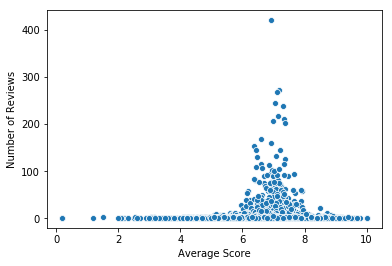

In [8]:
# Initial exploration: Examining the relationship between average review score 
# and number of reviews per record label

sns.scatterplot(x=label_df["avg_score"], y=label_df["count"])
plt.xlabel("Average Score")
plt.ylabel("Number of Reviews")
plt.show()

In [9]:
# Examining the descriptive stats 

label_df.describe()

,avg_score,count
count,3666.000000,3666.000000
mean,6.992975,5.497272
std,1.075392,17.986523
min,0.200000,1.000000
25%,6.500000,1.000000
50%,7.166667,1.000000
75%,7.700000,3.000000
max,10.000000,420.000000


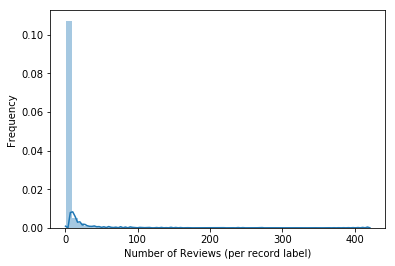

In [10]:
# Plotting the frequency of the number of reviews per record label

sns.distplot(label_df["count"])
plt.xlabel("Number of Reviews (per record label)")
plt.ylabel("Frequency")
plt.show()

When we look at the description and distribution plot above, we can see that most of our record labels only have one review each. If we were to simply sort our record labels based on average review scores, we might falsely come to the conclusion that the reviewers at the top or bottom of the list are the best record labels according to Pitchfork.

To illustrate:

In [11]:
# Looking simply at the top of the list, the labels with the highest scores
label_df.sort_values("avg_score", ascending=False).head()

,avg_score,count
label,,
rolling stones,10.0,1
geffen/get on down,10.0,1
enigma,10.0,1
volt,10.0,1
ace of hearts,9.8,1


In [12]:
# Looking simply at the bottom of the list, the labels with the lowest scores
label_df.sort_values("avg_score", ascending=True).head()

,avg_score,count
label,,
mud,0.2,1
buddyhead,0.2,1
compadre,0.2,1
boojm,1.2,1
trashy moped,1.5,2


Note that all of the record labels with both the best and the worst scores have only one review. Does that truly mean that albums from those labels are rated differently than the rest of the record labels? Probably not!

Knowing that just one review is not enough information to work with, I'm going to cull the record labels to remove any who have only one review, and see how this changes the distribution of my data.

In [13]:
# Making a new dataframe for labels with more than one review
# Note that this removes 2029 rows (labels)!

culled_label_df = label_df.loc[label_df["count"] > 5]
culled_label_df.describe()

,avg_score,count
count,577.000000,577.000000
mean,7.003073,26.327556
std,0.556745,39.206166
min,5.085714,6.000000
25%,6.662500,8.000000
50%,7.050000,13.000000
75%,7.376923,26.000000
max,8.916667,420.000000


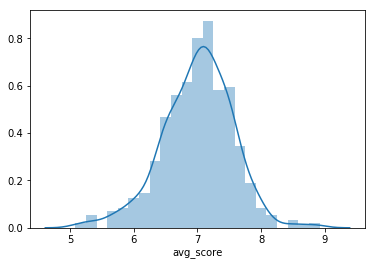

In [14]:
sns.distplot(culled_label_df["avg_score"])

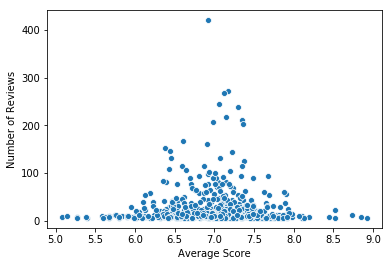

In [15]:
sns.scatterplot(x=culled_label_df["avg_score"], y=culled_label_df["count"])
plt.xlabel("Average Score")
plt.ylabel("Number of Reviews")
plt.show()

## Gaussian Naive Bayes

In [16]:
df.head()

,score,label
0,9.3,virgin
1,7.9,hathenter
2,7.3,static shock
3,7.3,fashionable idiots
4,9.0,kill rock stars


In [17]:
df["score"].describe()

count    20153.000000
mean         7.002923
std          1.304778
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64

In [18]:
# Defining the thresholds for our classes

class_threshold = []

for pcts in [.05, .25, .5, .75, .95]:
    class_threshold.append(df.quantile(q=pcts)[0])
    
class_threshold

[4.5, 6.4, 7.2, 7.8, 8.7]

In [31]:
# Defining our classes of reviews

def review_type(score):
    if score <= class_threshold[0]: # From 0 to 4.5, bottom 5%
        review_type = 0
    elif score <= class_threshold[1]: # From 4.5 to 6.4, next 20%
        review_type = 1
    elif score <= class_threshold[2]: # From 6.4 to 7.2, next 25%
        review_type = 2
    elif score <= class_threshold[3]: # From 7.2 to 7.8, next 25%
        review_type = 3
    elif score <= class_threshold[4]: # From 7.8 to 8.7, next 20%
        review_type = 4
    else: # Above 8.7, top 5%
        review_type = 5
    return review_type

In [32]:
df["review_type"] = df.score.map(lambda x: review_type(x))
df.head()

,score,label,review_type
0,9.3,virgin,5
1,7.9,hathenter,4
2,7.3,static shock,3
3,7.3,fashionable idiots,3
4,9.0,kill rock stars,5


In [33]:
df.review_type.value_counts()

2    5042
3    5030
4    4099
1    4096
0    1054
5     832
Name: review_type, dtype: int64

In [35]:
df.describe()

,score,review_type
count,20153.000000,20153.000000
mean,7.002923,2.472386
std,1.304778,1.274402
min,0.000000,0.000000
25%,6.400000,1.000000
50%,7.200000,2.000000
75%,7.800000,3.000000
max,10.000000,5.000000


In [36]:
aggs = df.groupby('review_type').agg(['mean', 'std'])
aggs

score          
                 mean       std
review_type                    
0            3.409867  0.971296
1            5.746509  0.503659
2            6.889468  0.218800
3            7.555547  0.170888
4            8.198683  0.243577
5            9.195553  0.362525

In [37]:
from scipy import stats

def p_x_given_class(obs_row, class_, feature="score"):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]

    obs = df.iloc[obs_row][feature] #observation
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y

In [38]:
p_x_given_class(0, 5)

1.0557168936016044

In [41]:
row = 100
c_probs = []
for c in range(6):
        p = len(df[df.review_type==c])/len(df) #Initialize probability to relative probability of class
        p *= p_x_given_class(row, c) #Update the probability using the point estimate for score
        c_probs.append(p)
c_probs

[3.0374512031020055e-07,
 7.240491930933456e-06,
 1.1618650249179368e-06,
 0.01979498204680401,
 0.2388549385129239,
 0.00019756097270099438]

In [42]:
def predict_class(row):
    c_probs = []
    for c in range(6):
        p = len(df[df.review_type==c])/len(df) #Initialize probability to relative probability of class
        p *= p_x_given_class(row, c)
        c_probs.append(p)
    return np.argmax(c_probs)

In [43]:
row = 0
df.iloc[row]

score             9.3
label          virgin
review_type         5
Name: 0, dtype: object

In [44]:
predict_class(row)

5

In [50]:
mini_df = df.loc[0:1001]
mini_df.shape

(999, 3)

In [51]:
mini_df['Predictions'] =  [predict_class(row) for row in mini_df.index]
mini_df['Correct?'] = mini_df['review_type'] == mini_df['Predictions']
mini_df['Correct?'].value_counts(normalize=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


False    0.547548
True     0.452452
Name: Correct?, dtype: float64